In this file, we first load the fMRI data for each voxel we want to prediction.
- We then calculate a text description for each voxel, which we hope will corresponding to a semantic concept
- Next, we visualize these concepts and select a couple best ones
- We visualize the best ones
- We then validate that the best ones are spatially close together

In [125]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from tqdm import tqdm
import pickle as pkl
import os
from os.path import join as oj
import cortex # brain viz library
from data_utils import neuro
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from model_utils import suffix
import string
from collections import defaultdict
from matplotlib.pyplot import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compute next-token completions

In [13]:
word_lists = neuro.fetch_data() # (10k voxels, 200 words)
n_words = 15
word_lists = word_lists[:, :n_words]

In [104]:
checkpoint = 'EleutherAI/gpt-j-6B' # 'gpt2-medium'
device = 'cuda'
save_dir = f'/home/chansingh/mntv1/fmri/logits_{checkpoint}'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    checkpoint, output_hidden_states=False).to(device)
batch_size = 10 # make sure this divides into word_lists.shape[0]
model = model.to(device)

In [105]:
def make_prompt_from_word_list(word_list):
    s = 'The following list of words are all part of the same semantic category: '
    s += ', '.join(word_list)
    s += '.\nThe semantic category they all belong to, in one word, is'
    return s

# run one example
s = make_prompt_from_word_list(word_lists[0]) 
ex_inputs = tokenizer([s], padding='longest', return_tensors='pt')
next_token_logits = suffix.get_next_token_logits(ex_inputs, model).squeeze().detach().cpu().numpy()

In [122]:
# iterate and store over all examples
os.makedirs(save_dir, exist_ok=True)
vocab_size = next_token_logits.shape[-1]
all_logits = np.zeros((word_lists.shape[0], vocab_size))

for i in tqdm(range(0, word_lists.shape[0], batch_size)): # batch_size is step
    s = [make_prompt_from_word_list(wlist) for wlist in word_lists[i: i + batch_size]]
    ex_inputs = tokenizer(s, padding='longest', return_tensors='pt').to(device)
    next_token_logits = suffix.get_next_token_logits(ex_inputs, model).detach().cpu().numpy()
    all_logits[i: i + batch_size] = next_token_logits
pkl.dump(all_logits, open(oj(save_dir, 'all_logits.pkl'), 'wb'))

100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


# Decode top tokens

In [126]:
all_logits = pkl.load(open(oj(save_dir, 'all_logits.pkl'), 'rb'))

In [128]:
STOPWORDS = suffix.get_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chansingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
def get_top_decoded_tokens(next_token_logits, top_k=20):
    # decode top tokens
    top_k_inds = np.arange(next_token_logits.size)
    top_k_inds = top_k_inds[np.argsort(next_token_logits[top_k_inds])][::-1]
    top_decoded_tokens = np.array(
        [tokenizer.decode(ind) for ind in top_k_inds])

    # remove nonsense
    STOPWORDS_PHRASING = ['called', 'simply', ]
    STOPWORDS_EXTRA = ['something']    
    disallowed_idxs = np.array([
        # general
        s.isspace() # space
        or all(c in string.punctuation for c in s.strip()) # punc
        or len(s) <= 3 # length
        or s == s.upper() # all CAPS tokens

        # keywords
        or s.lower().strip() in STOPWORDS # stopwords 
        or s.lower().strip() in STOPWORDS_PHRASING # stopwords  
        or s.lower().strip() in STOPWORDS_EXTRA # stopwords  

        # check if it is one of the inputs
        or s.strip().lower() in word_lists[0] # not one of the inputs
        or s.strip().lower() + 's' in word_lists[0] # plural not in inputs
        or s.strip().lower() in [word + 's' for word in word_lists[0]] # singular not in inputs
        for s in top_decoded_tokens],
        dtype=bool)
    top_k_inds = top_k_inds[~disallowed_idxs]
    top_decoded_tokens = top_decoded_tokens[~disallowed_idxs]
    return top_decoded_tokens[:top_k]

# Let's look at some example
for i in range(5):
    print(make_prompt_from_word_list(word_lists[i]))
    print(get_top_decoded_tokens(all_logits[i]))
    print()

The following list of words are all part of the same semantic category: sheet, edges, diameter, strips, cardboard, copper, steel, colored, coloured, leaf, wire, cap, paper, shaped, tin.
The semantic category they all belong to, in one word, is
[' material' ' metal' ' shape' ' surface' ' fabric' ' materials'
 ' packaging' ' box' ' plastic' ' card' ' colour' ' container' ' table'
 ' wood' ' part' ' cloth' ' Material' ' boxes' ' wall' ' color']

The following list of words are all part of the same semantic category: lighter, vertical, diameter, edges, horizontal, cap, rear, underneath, sheet, mounted, circular, cylinder, plate, mm, yellow.
The semantic category they all belong to, in one word, is
[' light' ' surface' ' color' ' cyl' ' cylinder' ' size' ' wall'
 ' dimension' ' shape' ' Light' ' colour' ' container' ' measurement'
 ' plate' ' thickness' ' vertical' ' metal' ' lighter' ' glass' ' weight']

The following list of words are all part of the same semantic category: cap, ink, ligh

In [ ]:
# look at recurring words over the top voxels
n_top_voxels = 20
decoded_token_counts = defaultdict(int)
for i in tqdm(range(n_top_voxels)):
    top_decoded_tokens = get_top_decoded_tokens(all_logits[i], top_k=20)
    for tok in top_decoded_tokens:
        decoded_token_counts[tok] += 1
for k, v in sorted(decoded_token_counts.items(), key=lambda x: x[1], reverse=True):
    if v > 1:
        print(repr(k), v)

In [169]:
# select a couple
concepts = [' material', ' color']
concept_ids = tokenizer.encode(concepts)
scores_list = [all_logits[:, concept_ids[i]] for i in range(len(concepts))]
meta = neuro.fetch_meta()

# Visualize scores

In [165]:
import cortex
def flatmap_quickshow(scores, mask, with_rois=True, with_labels=True,
                      vmin=0, vmax=0.5, cmap=cm.hot):
    """
    rois & labels require inkscape

    # there's also a fancy web version
    # cortex.webshow(corrvol, port=8889, open_browser=False)
    """

    corrvol = cortex.Volume(scores, "S1", "fullhead",
                            mask=mask, vmin=vmin, vmax=vmax, cmap=cmap)
    cortex.quickshow(corrvol, with_rois=with_rois, with_labels=with_labels, colorbar_location='right')

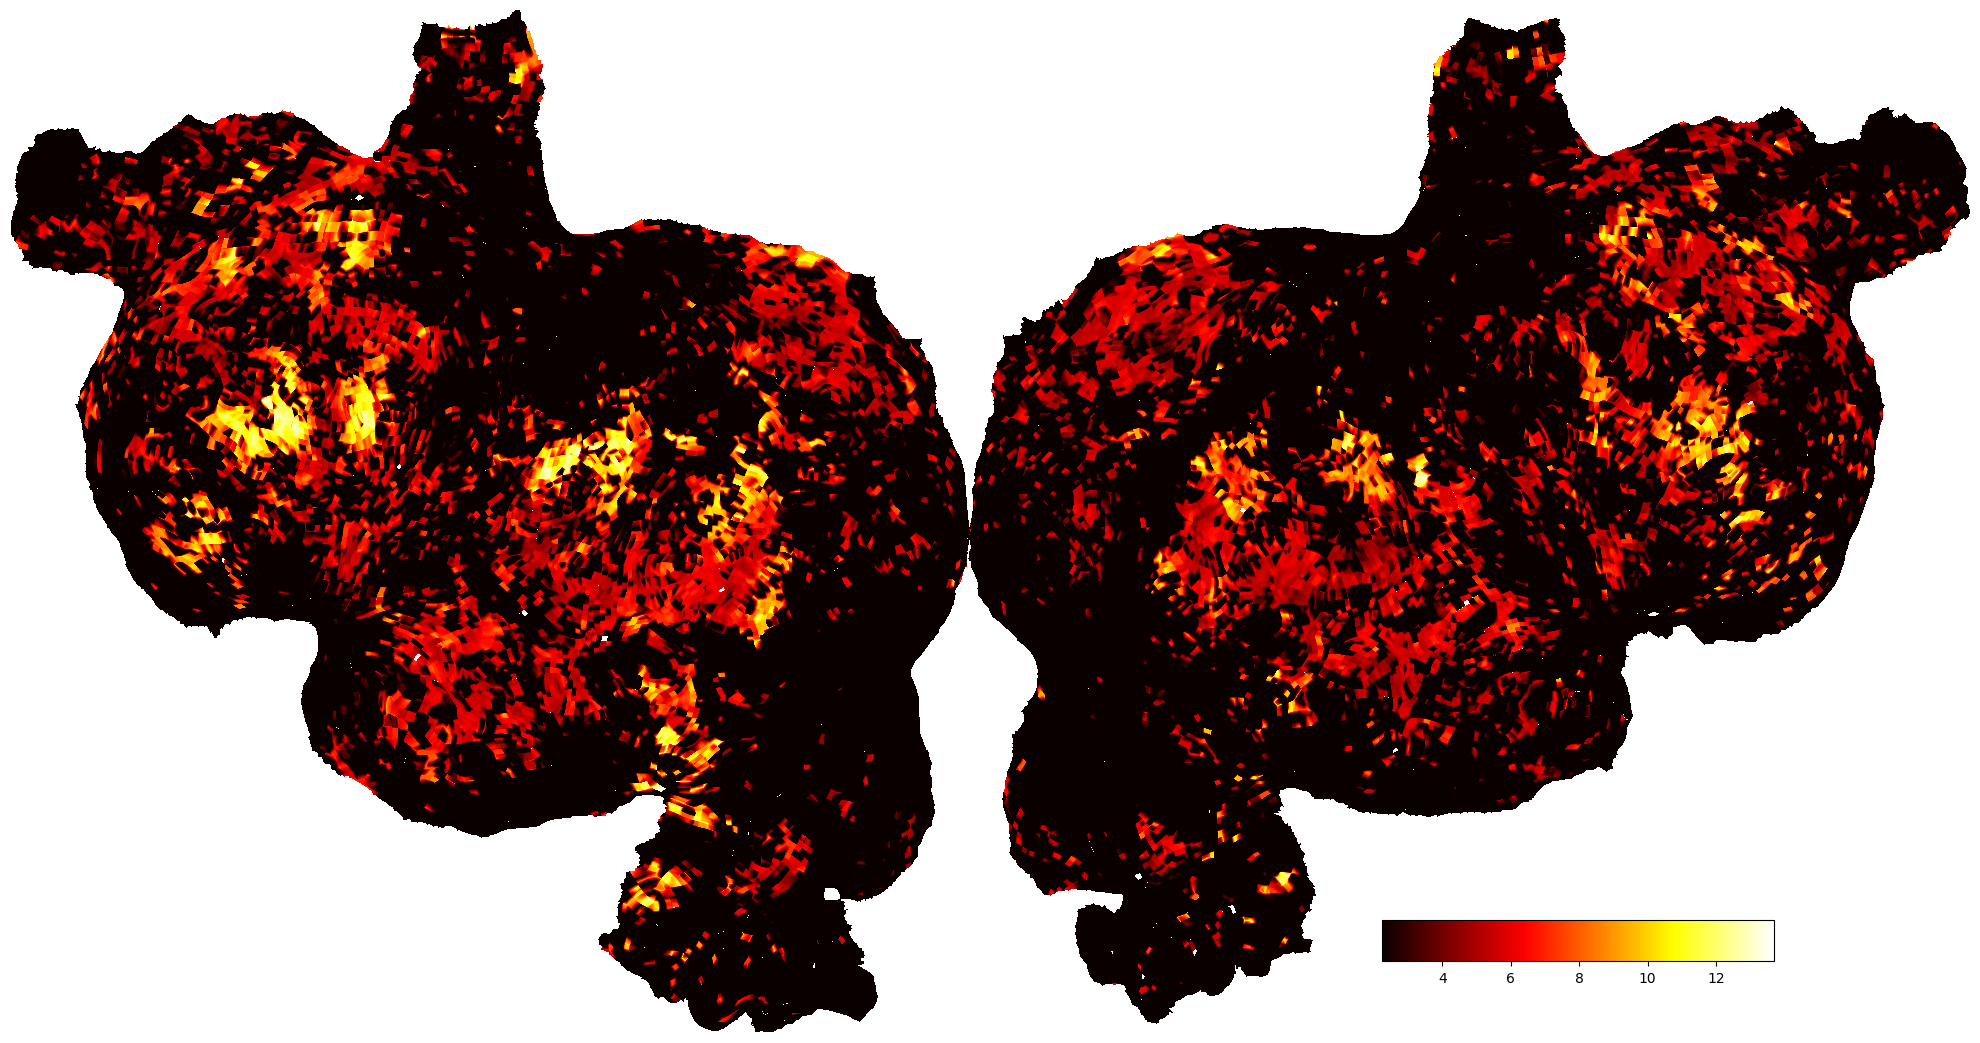

In [173]:
scores = scores_list[0]
scores_reshaped = neuro.remap_scores_best_to_scores_all(scores, meta['corrsort'])
flatmap_quickshow(scores_reshaped, meta['mask'], with_rois=True, with_labels=True, vmin=scores.min(), vmax=scores.max())

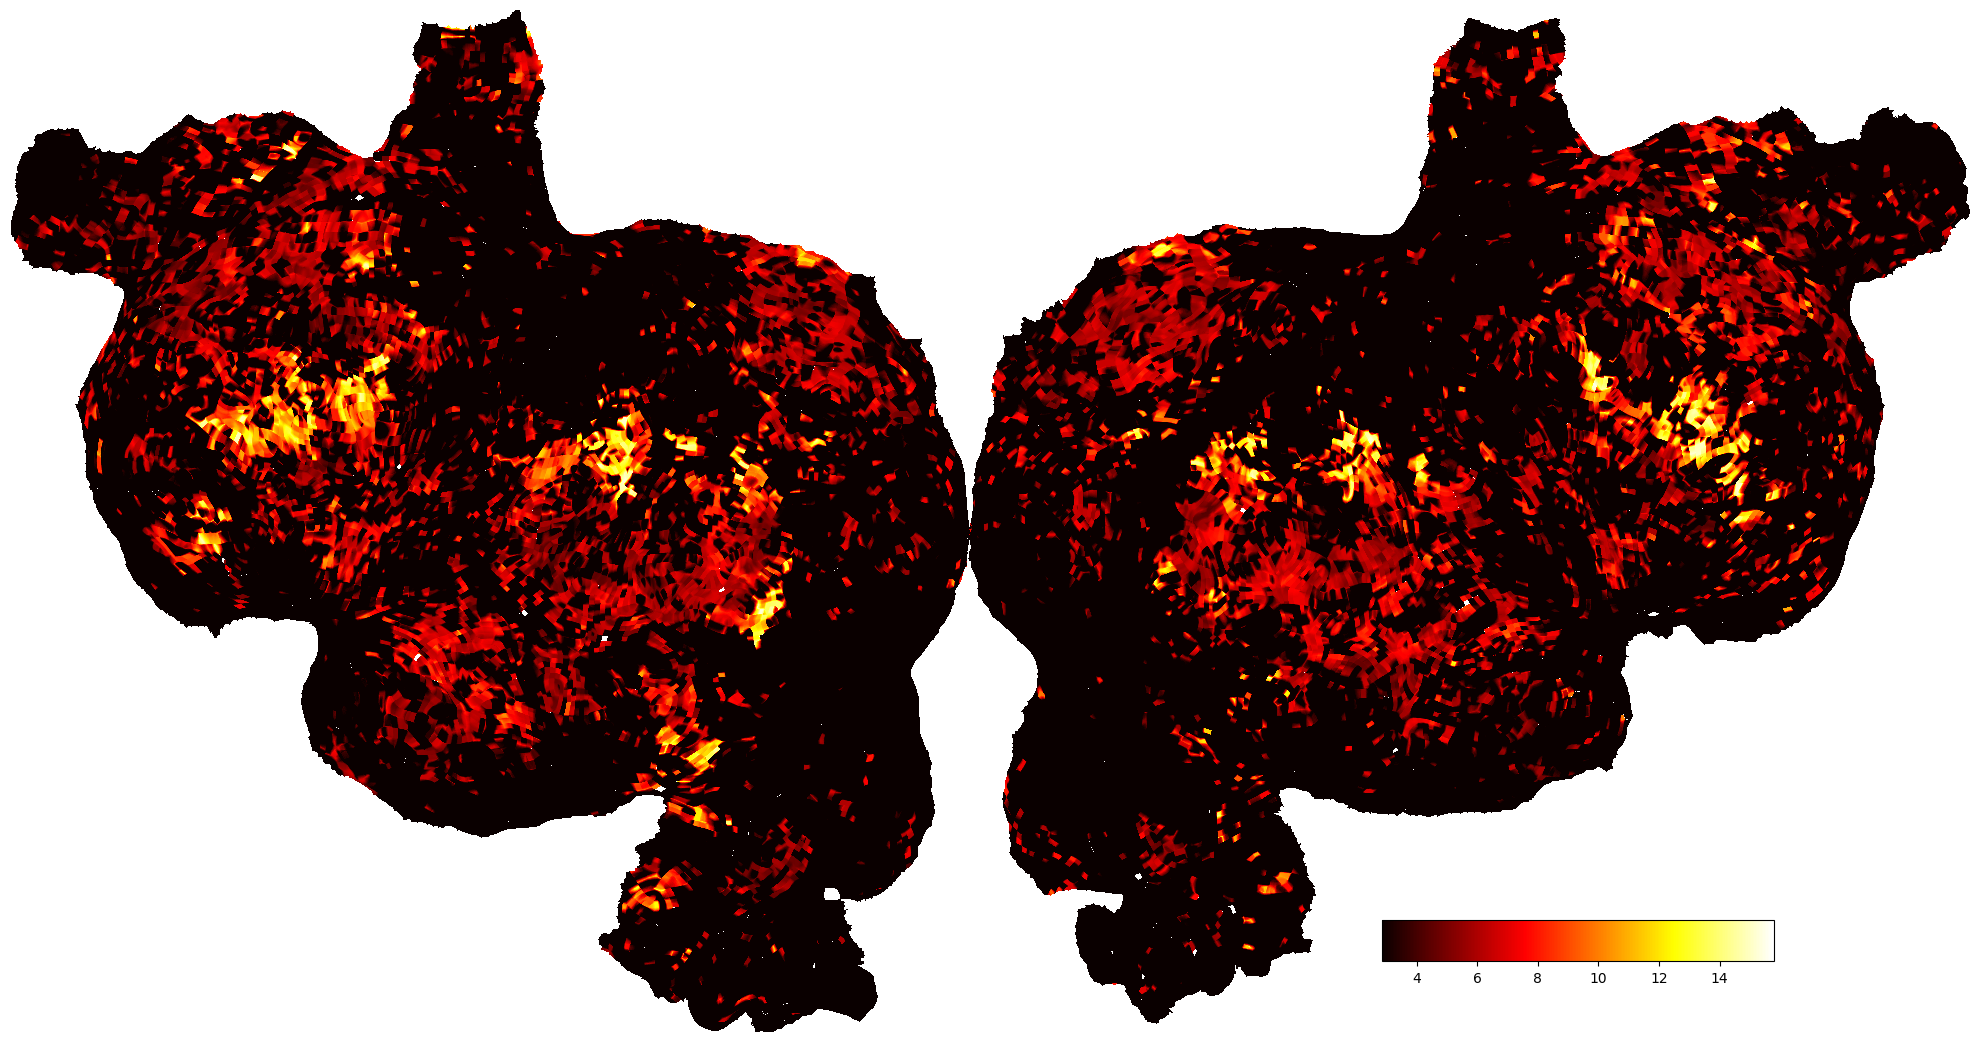

In [174]:
scores = scores_list[1]
scores_reshaped = neuro.remap_scores_best_to_scores_all(scores, meta['corrsort'])
flatmap_quickshow(scores_reshaped, meta['mask'], with_rois=False, with_labels=False, vmin=scores.min(), vmax=scores.max())

In [172]:
scores.max()

13.690901756286621